In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC  
import random
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('google_books.csv')
tfidf_one_hot_words = pd.read_csv('tfidf_one_hot_words.csv')
print(df.shape)

(1116, 14)


In [21]:
df.dropna(subset=['description'], inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(1111, 14)


title               subtitle               authors  \
0    The Litigators                    NaN          John Grisham   
1           Ragtime                A Novel         E.L. Doctorow   
2   Her Perfect Man                    NaN      Mary Lynn Baxter   
3  The Vanished Man  A Lincoln Rhyme Novel        Jeffery Deaver   
4        One Sunday                A Novel  Carrie Gerlach Cecil   

            publisher  month  year categories  pageCount  listPrice  images  \
0                Dell     10  2011    Fiction        496       9.99   False   
1        Random House     11  2010    Fiction        336      14.99    True   
2          Silhouette      5  2011    Fiction        192       3.99   False   
3  Simon and Schuster      8  2012    Fiction        577        NaN   False   
4  Simon and Schuster      2  2013    Fiction        255        NaN   False   

   isEbook  ratingsCount  averageRating  \
0     True           137            3.5   
1     True            57            3.5   
2     True             1            5.0   
3    False            19            4.0   
4    False             6            4.0   

                                         description  
0  The partners at Finley & Figg often refer to t...  
1  Selected by the Modern Library as one of the 1...  
2  One look at firebrand Katherine Mays and Bryce...  
3  Hunting down a killer and master illusionist w...  
4  When her unborn child's health is put at risk,...

## Feature Engineering

In [22]:
## target feature indicating if book gets a 4.5 rating or above
def above4p5(x):
    if x >= 4.5:
        return 1
    else:
        return 0

df['above4p5'] = df['averageRating'].map(lambda x: above4p5(x))

In [23]:
## make feature that indicates if popular or unpopular author 
## i.e. does the author appear more than once 
author_count = df.authors.value_counts()
popular_authors = list(author_count[author_count >= 3].index)

def popular_author(x):
    if x in popular_authors:
        return 1
    else:
        return 0

df['popular_author'] = df['authors'].map(lambda x: popular_author(x))
print(df['popular_author'].sum())

21


In [24]:
words = tfidf_one_hot_words.iloc[:,0:49]

df = pd.concat([ pd.get_dummies(df['publisher']), pd.get_dummies(df['month']), 
                     pd.get_dummies(df['year']), pd.get_dummies(df['categories']), 
                df['images'], df['isEbook'], df['popular_author'], df['above4p5']], axis=1)
df = pd.concat([df, words], join="inner", axis=1)
df.head()

A&C Black  A&amp;C Black  Abrams  Academic Press  Acculant Publishing  Ace  \
0          0              0       0               0                    0    0   
1          0              0       0               0                    0    0   
2          0              0       0               0                    0    0   
3          0              0       0               0                    0    0   
4          0              0       0               0                    0    0   

   Addison-Wesley  Addison-Wesley Professional  Adelphi Edizioni spa  \
0               0                            0                     0   
1               0                            0                     0   
2               0                            0                     0   
3               0                            0                     0   
4               0                            0                     0   

   African Books Collective  ...  year  guide  readers  recipes  man  novel  \
0                         0  ...     0      0        0        0    0      1   
1                         0  ...     0      0        0        0    0      1   
2                         0  ...     0      0        0        0    0      0   
3                         0  ...     0      0        0        0    0      0   
4                         0  ...     0      0        0        0    0      0   

   students  just  real  design  
0         0     0     0       0  
1         0     0     1       0  
2         0     0     0       0  
3         0     0     0       0  
4         0     0     0       0  

[5 rows x 465 columns]

##### Solving imbalances in the train test split due to uneven distribution of words

In [25]:
## this cell makes a train-test-split based on dataframe index
## it is taking random samples of words (column) and splitting it into a mini
## train-test dataframe then merging to a running tally of random samples
## once the running tally reaches approximately 75% of the main dataframe,
## the loop halts
freq_words = words.apply(np.sum, axis=0)

## initialze empty dataframes
train = pd.DataFrame(columns = df.columns)
test = pd.DataFrame(columns = df.columns)

## while loop until train dataframe reaches 75% of main df n_rows
while train.shape[0] <= round(len(df.index) * 0.75):
    ## sample a word and split in to train/test based on the word
    samp = freq_words[freq_words<100].sample(1).index[0]
    col = tfidf_one_hot_words[[samp]]

    ## gets all the rows where that word occurs
    col = col[col[samp]==1]

    ## estimate of how many rows we want in micro train dataset
    n_train = round(len(col.index) * 0.75)

    ## get a sample of the indices that go in to the micro train dataset
    inds = random.sample(range(0,len(col.index)), k=n_train)
    train_inds = [list(col.index)[ind] for ind in inds]

    ## takes difference between train indices and micro dataframe indices to get test in  dices
    test_inds = list(set(list(col.index))- set(train_inds))

    ## join the micro indices with the macro indices, which we will continue to add to
    train = pd.concat([train, df.iloc[train_inds]])
    test = pd.concat([test, df.iloc[test_inds]])

In [26]:
print(train.shape)
train.head()


(866, 465)


A&C Black A&amp;C Black Abrams Academic Press Acculant Publishing Ace  \
882         0             0      0              0                   0   0   
864         0             0      0              0                   0   0   
854         0             0      0              0                   0   0   
892         0             0      0              0                   0   0   
898         0             0      0              0                   0   0   

    Addison-Wesley Addison-Wesley Professional Adelphi Edizioni spa  \
882              0                           0                    0   
864              0                           0                    0   
854              0                           0                    0   
892              0                           0                    0   
898              0                           0                    0   

    African Books Collective  ... year guide readers recipes man novel  \
882                        0  ...    0     0       0       0   0     0   
864                        0  ...    0     0       0       0   0     0   
854                        0  ...    0     0       0       0   0     0   
892                        0  ...    0     0       1       0   0     0   
898                        0  ...    0     0       0       0   0     0   

    students just real design  
882        0    0    0      0  
864        0    0    0      0  
854        0    0    0      0  
892        0    0    0      0  
898        0    0    0      0  

[5 rows x 465 columns]

In [27]:
## manually making the train-test-split
X_train = df
y_train = train[['above4p5']]

X_test = test.drop(['above4p5'], axis=1)
y_test = test[['above4p5']]
                     
# x_sub = X_train.drop([''])


In [28]:
y_train=y_train.astype('int')
y_test = y_test.astype('int')
# X_train = X_train.astype()

## Baseline

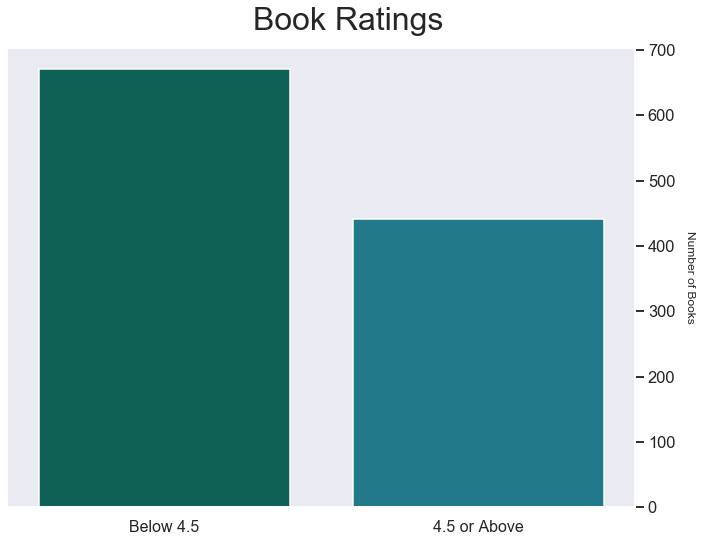

In [29]:
sns.set(style='dark', context='talk')
palette = sns.color_palette("PuBuGn_r")

f, ax = plt.subplots(figsize=(10,8))
f.suptitle('Book Ratings', ha='center', fontsize=32)
ax = sns.countplot(df['above4p5'], data=df, palette=palette)
ax.set_xlabel('')
ax.set_xticklabels(['Below 4.5', '4.5 or Above'], fontsize=16)
ax.set_ylabel('Number of Books', rotation=270, fontsize=12)
ax.yaxis.set_label_position('right')
ax.yaxis.set_label_coords(1.095, 0.5)
ax.yaxis.tick_right()
f.tight_layout(rect=[0, 0.03, 1, 0.95])


## Logistic Regression

In [57]:
## logistic regression without word vectors

X_train_sub = pd.concat([pd.get_dummies(df['publisher']), pd.get_dummies(df['month']), 
                   pd.get_dummies(df['year']), pd.get_dummies(df['categories']), 
                   df['images'], df['isEbook'], df['popular_author']], axis=1)
y = df['above4p5']




KeyError: 'publisher'

In [31]:
## logistic regression with word vectors

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f'Predicted values: \n {clf.predict(X_train)} \n')
print(f'Probability predctions: \n {clf.predict_proba(X_train)} \n')
print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Predicted values: 
 [1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1
 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0
 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1
 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0
 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1
 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0
 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1
 1 1 

## Decision Trees

##### Random Forest

In [ ]:
## random forest without word vectors


In [32]:
## random forest with word vectors

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print(f'Predicted values: \n {clf.predict(X_train)} \n')
print(f'Probability pridctions: \n {clf.predict_proba(X_train)} \n')
print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

# print(f'Parameters: \n {grid_random_forest.best_params_} \n')
# print(f'Train score: \n {grid_random_forest.best_score_} \n')
# print(f'Test score: \n {grid_random_forest.score(X_test, y_test)}')

Predicted values: 
 [1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1
 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1
 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1
 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1
 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 1
 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0
 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1
 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0
 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1
 1 1 

In [34]:
## with grid search

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

grid_random_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid_random_forest.fit(X_train, y_train)

print(f'Parameters: \n {grid_random_forest.best_params_} \n')
print(f'Train score: \n {grid_random_forest.best_score_} \n')
print(f'Test score: \n {grid_random_forest.score(X_test, y_test)}')

Parameters: 
 {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2} 

Train score: 
 0.7863741339491916 

Test score: 
 0.9106529209621993


##### AdaBoost

In [35]:
## AdaBoost without word vectors
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Train score: 
 0.8394919168591224 

Test score: 
 0.7628865979381443


##### Gradient Boost

In [53]:
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train, y_train)

gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

def display_acc_and_f1_score(true, preds):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Train scores:")
display_acc_and_f1_score(y_train, gbt_clf_train_preds)
print("\nTest scores:")
display_acc_and_f1_score(y_test, gbt_clf_test_preds)


Train scores:
Accuracy: 0.8879907621247113
F1-Score: 0.8928176795580111

Test scores:
Accuracy: 0.8109965635738832
F1-Score: 0.8318042813455658


##### XGBoost

In [47]:
clf = XGBClassifier()

## solving errors indicating some values were being passed as strings
X_train = X_train.astype(int)
X_test = X_test.astype(int)

clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f'Train Score: \n {training_accuracy} \n')
print(f'Test score: \n {test_accuracy}')

Train Score: 
 0.874133949191686 

Test score: 
 0.8384879725085911


## Support Vector Machine

In [48]:
svclassifier = SVC(kernel='rbf', C=1000)  
svclassifier.fit(X_train, y_train) 

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " " + str(accuracy_score(y_test, y_pred)))

[[120  14]
 [ 17 140]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       134
           1       0.91      0.89      0.90       157

    accuracy                           0.89       291
   macro avg       0.89      0.89      0.89       291
weighted avg       0.89      0.89      0.89       291

The accuracy score is 0.8934707903780069


## Naive Bayes

In [49]:
## NB wasn't good for the task, it had the lowest score of all the models

clf = BernoulliNB()
clf.fit(X_train, y_train)

print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Train score: 
 0.7390300230946882 

Test score: 
 0.6838487972508591


## Best Model Evaluation

In [ ]:
## Evaluate the random forest, print the diagram and shit 

In [54]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20)

AttributeError: 'BernoulliNB' object has no attribute 'feature_importances_'